<a href="https://colab.research.google.com/github/annkvth/kompleteNetze/blob/main/network_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to process either our own extracted flightlists, or excerpts of the data from "Crowdsourced air traffic data from The OpenSky Network 2020",
https://zenodo.org/records/7923702


In [1]:
!pip install traffic

Include libraries

In [51]:
from datetime import datetime, timedelta
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Always use python engine for dataframe queries, see
https://stackoverflow.com/questions/67063643/is-there-a-way-to-force-pandas-dataframe-query-to-use-python-as-default-engine

In [3]:
from functools import partialmethod

pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine="python")



Mount google drive to get the csv files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os

# where to save the data (and making shure that the directory exist)
folder_path = "/content/drive/My Drive/2024KomplexeNetze/Daten"
if not os.path.exists(folder_path):
    print(f'No such folder: {folder_path}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


List all the csv files in the folder.

In [5]:
import glob

csv_files = glob.glob(os.path.join(folder_path, "*deutschland*.csv"))
print(csv_files)

['/content/drive/My Drive/2024KomplexeNetze/Daten/2024-01-01_2024-04-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2024-04-01_2024-07-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-04-01_2023-07-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-01-01_2023-04-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-04-01_2019-07-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-07-01_2019-10-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-07-01_2023-10-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-10-01_2024-01-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-10-01_2020-01-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-01-01_2019-04-01_deutschland.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-10-01_2019-01-01_deutschland.csv', '/content/drive/My D

Testing with a single file for now....
Read into a pandas dataframe.

In [6]:
flightdata = pd.read_csv(csv_files[13], parse_dates=["firstseen", "lastseen", "day"])
print(csv_files[13])

/content/drive/My Drive/2024KomplexeNetze/Daten/2018-01-01_2018-04-01_deutschland.csv


Quick check what we got from the file...

In [7]:
flightdata.head()

,icao24,firstseen,departure,lastseen,arrival,callsign,day
0,3006b5,2018-01-01 20:30:00+00:00,EDDF,2018-01-01 21:25:00+00:00,LIMA,DLH304,2018-01-01 00:00:00+00:00
1,3006b5,2018-01-01 17:53:10+00:00,NaN,2018-01-01 18:56:35+00:00,EDDF,DLH6NH,2018-01-01 00:00:00+00:00
2,3006b5,2018-01-01 15:49:22+00:00,EDDF,2018-01-01 16:38:23+00:00,LIPO,DLH264,2018-01-01 00:00:00+00:00
3,3006b5,2018-01-01 13:30:49+00:00,LIMF,2018-01-01 14:29:11+00:00,EDDF,DLH1RL,2018-01-01 00:00:00+00:00
4,3006b5,2018-01-01 11:40:35+00:00,EDDF,2018-01-01 12:33:51+00:00,LIMA,DLH8PM,2018-01-01 00:00:00+00:00


In [ ]:
flightdata.describe()

,icao24,firstseen,departure,lastseen,arrival,callsign,day
count,317675,317353,268158,317675,278875,310493,317675
unique,8661,NaN,662,NaN,844,17503,NaN
top,300393,NaN,EDDF,NaN,EDDF,SIA26,NaN
freq,634,NaN,47221,NaN,49005,174,NaN
mean,NaN,2018-02-15 09:09:37.535993088+00:00,NaN,2018-02-15 11:27:54.039918336+00:00,NaN,NaN,2018-02-14 21:38:19.659714816+00:00
min,NaN,2018-01-01 00:00:03+00:00,NaN,2018-01-01 00:22:13+00:00,NaN,NaN,2018-01-01 00:00:00+00:00
25%,NaN,2018-01-24 14:17:22+00:00,NaN,2018-01-24 16:23:31+00:00,NaN,NaN,2018-01-24 00:00:00+00:00
50%,NaN,2018-02-15 19:46:30+00:00,NaN,2018-02-15 21:40:26+00:00,NaN,NaN,2018-02-15 00:00:00+00:00
75%,NaN,2018-03-09 10:22:54+00:00,NaN,2018-03-09 12:21:33.500000+00:00,NaN,NaN,2018-03-09 00:00:00+00:00
max,NaN,2018-03-29 22:39:31+00:00,NaN,2018-03-29 23:49:49+00:00,NaN,NaN,2018-03-29 00:00:00+00:00


Check for empty fileds in the data - there seem to be a few...

In [8]:
nan_percentage = (flightdata.isna().sum() / len(flightdata)) * 100
print(nan_percentage)

icao24        0.000000
firstseen     0.101361
departure    15.587314
lastseen      0.000000
arrival      12.213740
callsign      2.260801
day           0.000000
dtype: float64


Should we drop this data? Spend more time figuring out where it comes from? (e.g. if there is another entry with the same callsign and time, but complete)

In [17]:
flightdata.dropna(inplace=True)
flightdata.describe()

,icao24,firstseen,departure,lastseen,arrival,callsign,day,icao_x,departure_city,icao_y,arrival_city,week_and_year,month_and_year
count,227135,227135,227135,227135,227135,227135,227135,227135,227135,227135,227135,227135,227135
unique,6732,NaN,634,NaN,817,13113,NaN,634,592,817,758,13,3
top,4408df,NaN,EDDF,NaN,EDDF,HUMMEL3,NaN,EDDF,Frankfurt am Main,EDDF,Frankfurt am Main,2018-11,2018-03
freq,595,NaN,35605,NaN,34289,156,NaN,35605,35605,34289,34289,19834,80216
mean,NaN,2018-02-15 19:13:16.284575488+00:00,NaN,2018-02-15 21:17:22.688454400+00:00,NaN,NaN,2018-02-15 07:19:38.941158912+00:00,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2018-01-01 00:17:10+00:00,NaN,2018-01-01 00:38:11+00:00,NaN,NaN,2018-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2018-01-25 05:37:17+00:00,NaN,2018-01-25 07:04:10+00:00,NaN,NaN,2018-01-25 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2018-02-16 10:30:20+00:00,NaN,2018-02-16 12:08:59+00:00,NaN,NaN,2018-02-16 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2018-03-09 15:07:09+00:00,NaN,2018-03-09 17:04:09.500000+00:00,NaN,NaN,2018-03-09 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2018-03-29 22:39:31+00:00,NaN,2018-03-29 23:49:49+00:00,NaN,NaN,2018-03-29 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN


----


In [10]:
from traffic.data import airports
import altair as alt

Add city names to the airports

In [11]:
flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
flightdata = flightdata.rename(columns={"municipality": "departure_city"})
flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
flightdata = flightdata.rename(columns={"municipality": "arrival_city"})



airports @ourairports.com:   0%|          | 0/3584 [00:00<?, ?it/s]

In [12]:
# add a column to flightdata dataframe with contains week-and-year
flightdata['week_and_year'] = flightdata['day'].dt.strftime('%Y-%U')
flightdata.tail()


,icao24,firstseen,departure,lastseen,arrival,callsign,day,icao_x,departure_city,icao_y,arrival_city,week_and_year
227888,3c66a2,2018-03-29 05:24:22+00:00,EIDW,2018-03-29 07:00:25+00:00,EDDF,DLH983,2018-03-29 00:00:00+00:00,EIDW,Dublin,EDDF,Frankfurt am Main,2018-12
227889,4ca5ec,2018-03-29 18:15:12+00:00,EIDW,2018-03-29 19:41:18+00:00,EDFH,RYR88KF,2018-03-29 00:00:00+00:00,EIDW,Dublin,EDFH,Frankfurt am Main (Lautzenhausen),2018-12
227890,4ca5ec,2018-03-29 15:34:01+00:00,EDFH,2018-03-29 17:07:28+00:00,EIWT,RYR99NG,2018-03-29 00:00:00+00:00,EDFH,Frankfurt am Main (Lautzenhausen),EIWT,Leixlip,2018-12
227891,4ca5ec,2018-03-29 06:44:55+00:00,EGSS,2018-03-29 07:43:25+00:00,EDFH,RYR67VL,2018-03-29 00:00:00+00:00,EGSS,London,EDFH,Frankfurt am Main (Lautzenhausen),2018-12
227892,71be37,2018-03-29 04:26:33+00:00,RKSI,2018-03-29 15:36:51+00:00,EDDF,KAL905,2018-03-29 00:00:00+00:00,RKSI,Seoul,EDDF,Frankfurt am Main,2018-12


In [13]:
# add a column to flightdata dataframe with contains month-and-year
flightdata['month_and_year'] = flightdata['day'].dt.strftime('%Y-%m')
flightdata.tail()

,icao24,firstseen,departure,lastseen,arrival,callsign,day,icao_x,departure_city,icao_y,arrival_city,week_and_year,month_and_year
227888,3c66a2,2018-03-29 05:24:22+00:00,EIDW,2018-03-29 07:00:25+00:00,EDDF,DLH983,2018-03-29 00:00:00+00:00,EIDW,Dublin,EDDF,Frankfurt am Main,2018-12,2018-03
227889,4ca5ec,2018-03-29 18:15:12+00:00,EIDW,2018-03-29 19:41:18+00:00,EDFH,RYR88KF,2018-03-29 00:00:00+00:00,EIDW,Dublin,EDFH,Frankfurt am Main (Lautzenhausen),2018-12,2018-03
227890,4ca5ec,2018-03-29 15:34:01+00:00,EDFH,2018-03-29 17:07:28+00:00,EIWT,RYR99NG,2018-03-29 00:00:00+00:00,EDFH,Frankfurt am Main (Lautzenhausen),EIWT,Leixlip,2018-12,2018-03
227891,4ca5ec,2018-03-29 06:44:55+00:00,EGSS,2018-03-29 07:43:25+00:00,EDFH,RYR67VL,2018-03-29 00:00:00+00:00,EGSS,London,EDFH,Frankfurt am Main (Lautzenhausen),2018-12,2018-03
227892,71be37,2018-03-29 04:26:33+00:00,RKSI,2018-03-29 15:36:51+00:00,EDDF,KAL905,2018-03-29 00:00:00+00:00,RKSI,Seoul,EDDF,Frankfurt am Main,2018-12,2018-03


Generate the list of international airpots = airports not in my icaolist

Load the flightdata into networkx


In [97]:
# Create a graph from the departure and arrival cities
# flightdata.dropna(inplace=True) # I failed to get some cities, it seems

# filter, using those where departure and arrival both start with ED
flightdata_de= flightdata[flightdata['departure'].str.startswith('ED') & flightdata['arrival'].str.startswith('ED')]

edges = flightdata_de[['departure', 'arrival']].values
trafficgraph = nx.from_edgelist(edges)
# the weight of each edge should be how often the connection appears in the dataframe
for edge in trafficgraph.edges:
    trafficgraph[edge[0]][edge[1]]['weight'] = len(flightdata[(flightdata['departure'] == edge[0]) & (flightdata['arrival'] == edge[1])])


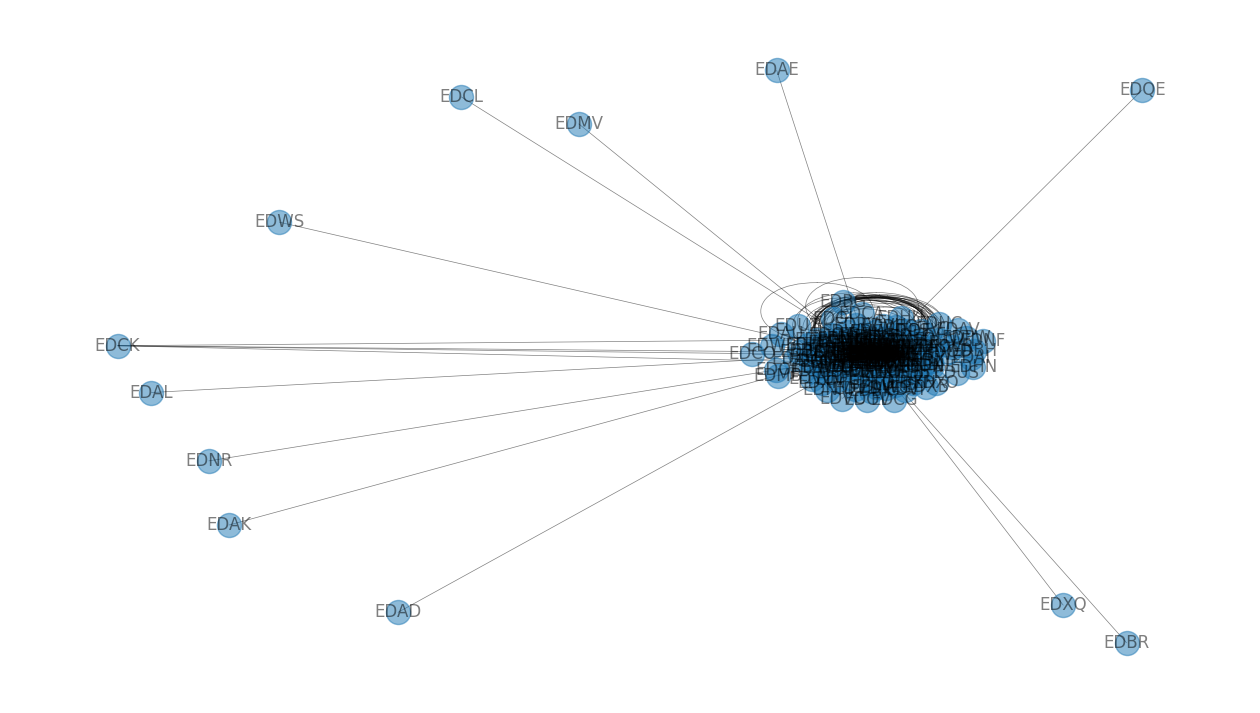

In [98]:
# first attempt at drawing:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
nx.draw_networkx(trafficgraph, ax=ax, alpha=0.5, width=0.5)
ax.set_axis_off()

In [99]:
# get degree of node EDDH
print(trafficgraph.degree('EDDH'))

# get degree of node EDXW
print(trafficgraph.degree('EDXW'))



85
46


In [100]:
# filter airports data to only contain rows with valid entries for latitude and longitude
airports_withpos = airports.data[airports.data['latitude'].notna() & airports.data['longitude'].notna()]

# replace index with icao
airports_withpos.set_index('icao', inplace=True)
airports_withpos.head()



,name,iata,latitude,longitude,country,altitude,type,municipality
icao,,,,,,,,
00A,Total RF Heliport,None,40.070985,-74.933689,United States,11.0,heliport,Bensalem
00AA,Aero B Ranch Airport,None,38.704022,-101.473911,United States,3435.0,small_airport,Leoti
00AK,Lowell Field,None,59.947733,-151.692524,United States,450.0,small_airport,Anchor Point
00AL,Epps Airpark,None,34.864799,-86.770302,United States,820.0,small_airport,Harvest
00AN,Katmai Lodge Airport,None,59.093287,-156.456699,United States,80.0,small_airport,King Salmon


In [107]:
# let's try on a map instead

# get position info from traffic library too
pos = {airport: (v['longitude'], v['latitude'])
       for airport, v in airports_withpos.to_dict('index').items()}

# Create a new graph with node attributes
new_graph = nx.Graph()

# Add nodes and their positions from trafficgraph, copying also the weighs
for node in trafficgraph.nodes:
    new_graph.add_node(node, pos=pos[node])

# Add edges from the original graph, COPYING als the weights
new_graph.add_edges_from([(u,v, {'weight': trafficgraph[u][v]['weight']}) for u,v in trafficgraph.edges])

# print number of nodes
print(len(new_graph.nodes))


181


In [108]:
# get the average weight of all nodes in the graph
print(sum(nx.get_edge_attributes(trafficgraph, 'weight').values())/len(trafficgraph.edges))
print(sum(nx.get_edge_attributes(new_graph, 'weight').values())/len(new_graph.edges))

24.4260162601626
24.4260162601626


In [103]:
# count how often Westerland appears
print(flightdata['departure'].value_counts()['EDXW'])

# count how often Hamburg appears
print(flightdata['departure'].value_counts()['EDDH'])


152
11693


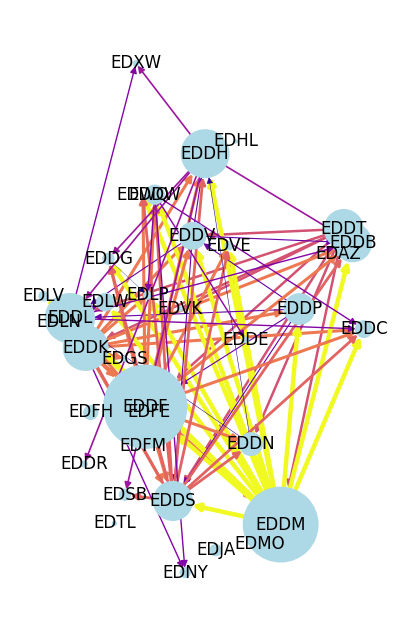

In [135]:
# remove self-loop edges
new_graph.remove_edges_from(nx.selfloop_edges(new_graph))

# Create a new graph
new_graph_filtered = nx.DiGraph()

# drop all nodes that do not start with the string ED
for node in new_graph.nodes:
    if  new_graph.degree(node) > 20 and node.startswith('ED'):
        new_graph_filtered.add_node(node, pos=new_graph.nodes[node]['pos'])

# Add edges from new_graph, if they have weight larger than 20
new_graph_filtered.add_edges_from([(u,v) for u,v in new_graph.edges if u in new_graph_filtered.nodes and v in new_graph_filtered.nodes and new_graph[u][v]['weight'] > 10])

# Color edges based on outgoing degree
edge_colors = []
for u, v in new_graph_filtered.edges:
  edge_colors.append(new_graph_filtered.out_degree(u,weight="weight"))


edge_width = []
# fill with edge_colors multiplied by 0.2
for edge in edge_colors:
  edge_width.append(edge*0.2)

# get max value from edge_colors list
vmax = max(edge_colors)
# get min value from edge_colors list
vmin = min(edge_colors)

# for the node size, look up the value_counts of the node in flightdata
node_sizes = []
for node in new_graph_filtered.nodes:
  node_sizes.append(0.1*flightdata['departure'].value_counts()[node])

# get fig and ax with size 5,8
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
# Draw the filtered graph with colored edges
cmap = plt.cm.plasma
nx.draw(new_graph_filtered, nx.get_node_attributes(new_graph_filtered, 'pos'),
        with_labels=True, node_size=node_sizes, node_color='lightblue',
        edge_color=edge_colors, edge_cmap=cmap, ax=ax, width=edge_width)

#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
#sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax)
#save figure
plt.savefig('network_de.svg')
plt.savefig('network_de.png', dpi=300)

plt.show()